In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(
    context="talk",
    style="whitegrid",
    rc={
        "figure.figsize": (16, 8),
        "figure.dpi": 100,
    },
)

# Data Loading

In [5]:
!cd ..; dvc repro ensemble_10km_test

ERROR: Stage 'ensemble_10km_test' not found inside 'dvc.yaml' file39m>


In [6]:
prepared_dataset = pathlib.Path("../datasets/prepared/ensemble_10km_test/full.hdf")

X = pd.read_hdf(prepared_dataset, key="inputs")
y = pd.read_hdf(prepared_dataset, key="outputs")
Xy = pd.read_hdf(prepared_dataset, key="inputs_outputs")

<AxesSubplot:xlabel='melt_rate', ylabel='SLC'>

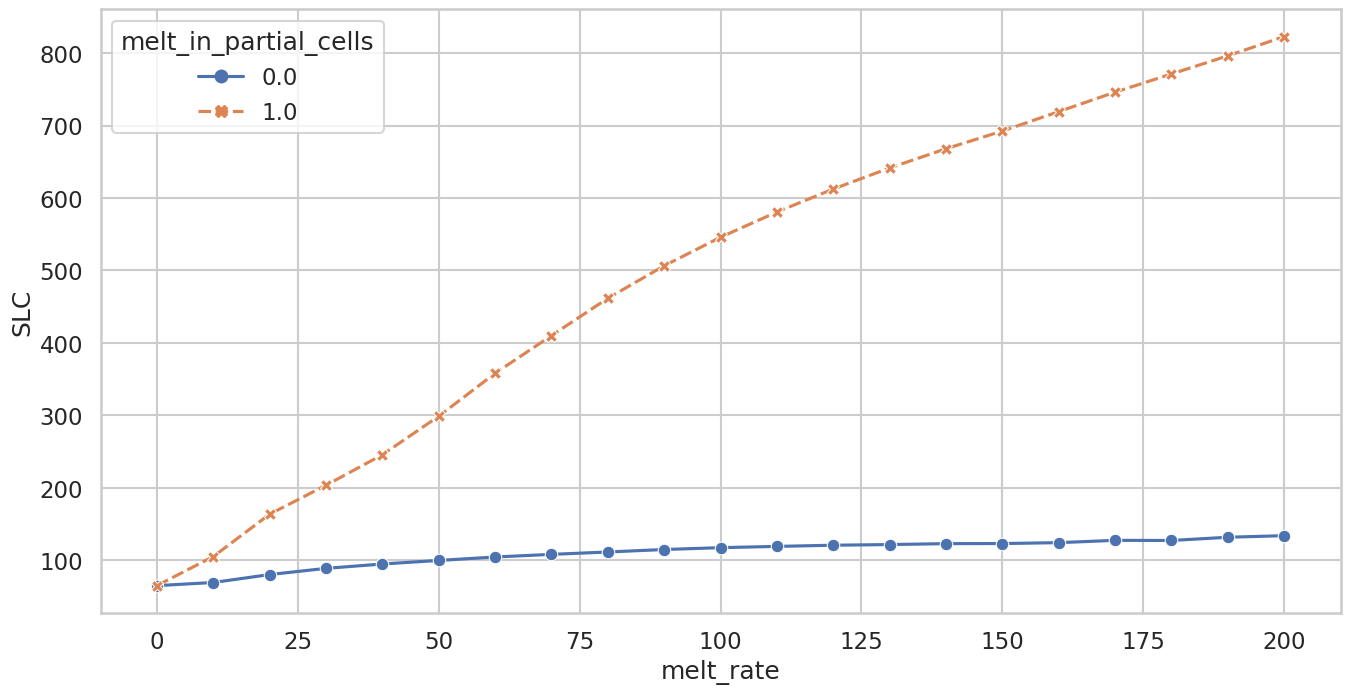

In [7]:
sns.lineplot(
    x="melt_rate",
    y="SLC",
    hue="melt_in_partial_cells",
    style="melt_in_partial_cells",
    data=Xy,
    markers=True,
)

# Modelling

In [8]:
import GPy

In [9]:
indexers = [
    X["melt_in_partial_cells"] == 0.0,
    X["melt_in_partial_cells"] == 1.0,
]
indexers = [indexer.values for indexer in indexers]

In [10]:
X_test = np.mgrid[-20.0:220.0:200j][:, None]
X_test_indexers = [
    np.zeros_like(X_test),
    np.ones_like(X_test),
]

colors = ["C0", "C1"]

In [11]:
Xs = [X.values[indexer][:, [0]] for indexer in indexers]
ys = [y.values[indexer] for indexer in indexers]

In [12]:
import wavi_on_ray


def coreg_model(Xs, ys, with_linear=False):
    if with_linear:
        kernels = ["bias", "linear", "matern32"]
    else:
        kernels = ["bias", "matern32"]
    model = wavi_on_ray.ensemble_10km_test.modelling.build_model(Xs, ys, kernels)
    
    model.optimize_restarts(num_restarts=3)
    return model

In [13]:
def plot_model(coreg_model, Xs, ys):
    sns.lineplot(
        x="melt_rate",
        y="SLC",
        hue="melt_in_partial_cells",
        style="melt_in_partial_cells",
        data=Xy,
        markers=True,
    )

    for X, y in zip(Xs, ys):
        plt.scatter(X, y, marker="o", c="black", alpha=0.8, s=250)

    for indexer, color in zip(X_test_indexers, colors):
        y_test, y_test_var = coreg_model.predict(
            np.hstack([X_test, indexer]),
            Y_metadata={"output_index": indexer.astype(int)},
        )
        y_test_std = np.sqrt(y_test_var)
        plt.plot(X_test, y_test, c=color)
        plt.fill_between(
            X_test[..., 0],
            y_test[..., 0] - 2 * y_test_std[..., 0],
            y_test[..., 0] + 2 * y_test_std[..., 0],
            color=color,
            alpha=0.4,
        )

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/3, f = 129.27608287818052
Optimization restart 2/3, f = 129.27604883269953
Optimization restart 3/3, f = 129.27605669053423


Text(0.5, 1.0, 'Full Data')

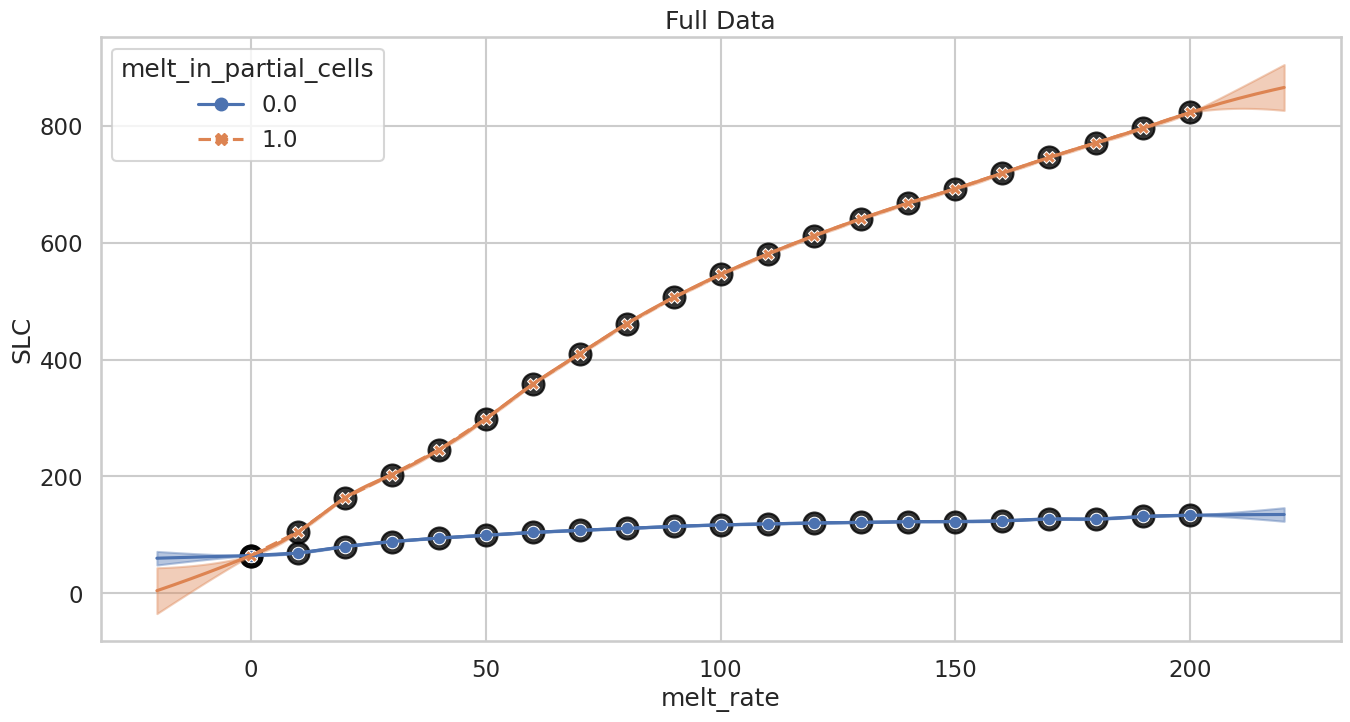

In [14]:
plot_model(coreg_model(Xs, ys), Xs, ys)

plt.title("Full Data")

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/3, f = 34.796716634210775
Optimization restart 2/3, f = 34.79670926047184
Optimization restart 3/3, f = 34.79668915645467


gp.,value,constraints,priors
sum.ICM0.bias.variance,0.3051141885072421,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.998861355407,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,247.78841241216233,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


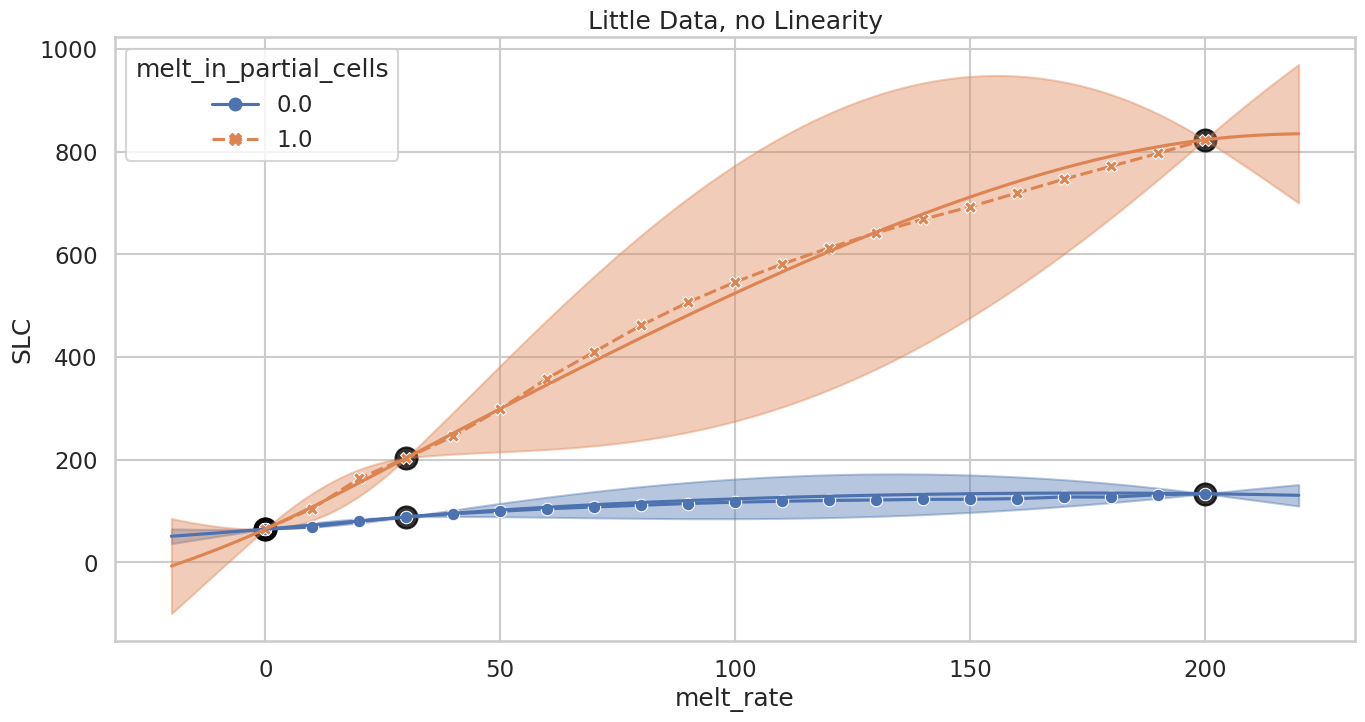

In [15]:
Xs_sub = [
    Xs[0][[0, 3, 20]],
    Xs[1][[0, 3, 20]],
]

ys_sub = [
    ys[0][[0, 3, 20]],
    ys[1][[0, 3, 20]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/3, f = 25.140178119952118
Optimization restart 2/3, f = 21.894215431415898
Optimization restart 3/3, f = 21.917736913168675


gp.,value,constraints,priors
sum.ICM0.bias.variance,18.1593081305096,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.0023330856101177935,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,99.99999980858298,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,353.4948529988016,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


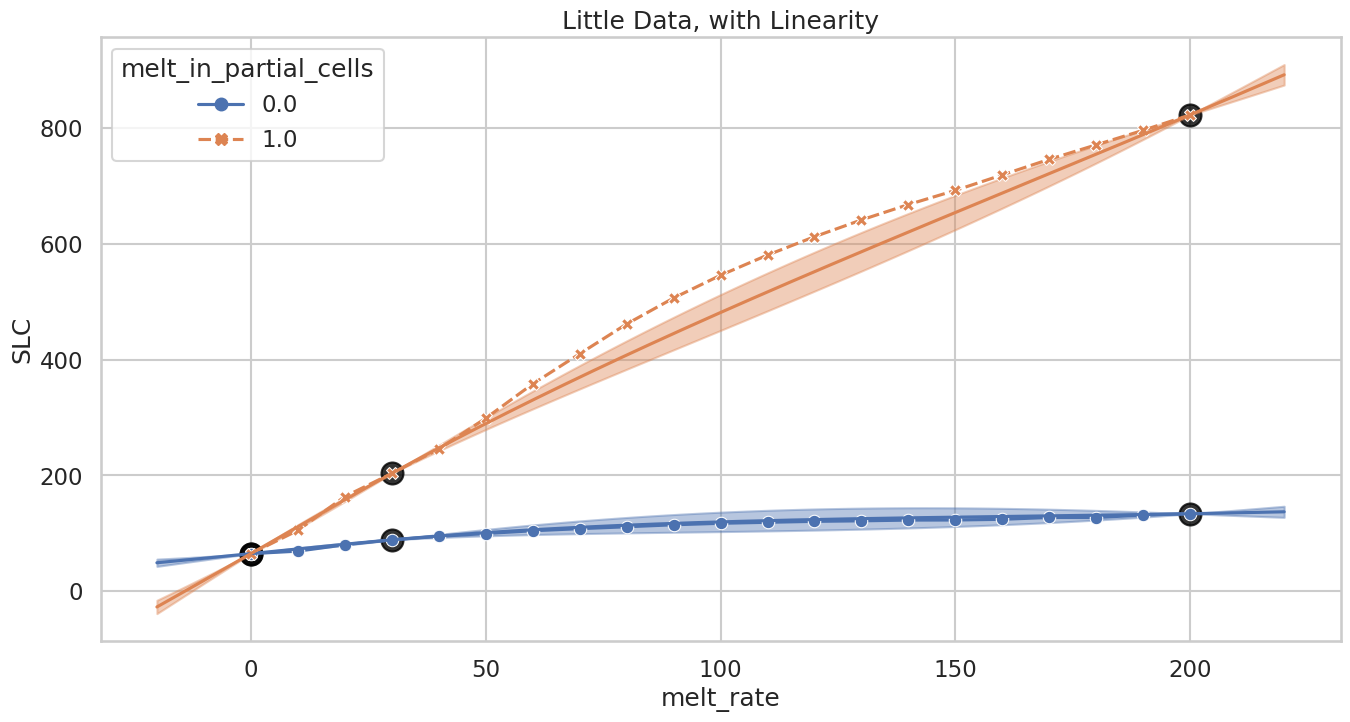

In [16]:
Xs_sub = [
    Xs[0][[0, 3, 20]],
    Xs[1][[0, 3, 20]],
]

ys_sub = [
    ys[0][[0, 3, 20]],
    ys[1][[0, 3, 20]],
]


model = coreg_model(Xs_sub, ys_sub, with_linear=True)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, with Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/3, f = 44.11688360423743
Optimization restart 2/3, f = 44.116977235802004
Optimization restart 3/3, f = 44.11700327357314


gp.,value,constraints,priors
sum.ICM0.bias.variance,0.0009510010269155133,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.89156686564776,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,275.07466546022846,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


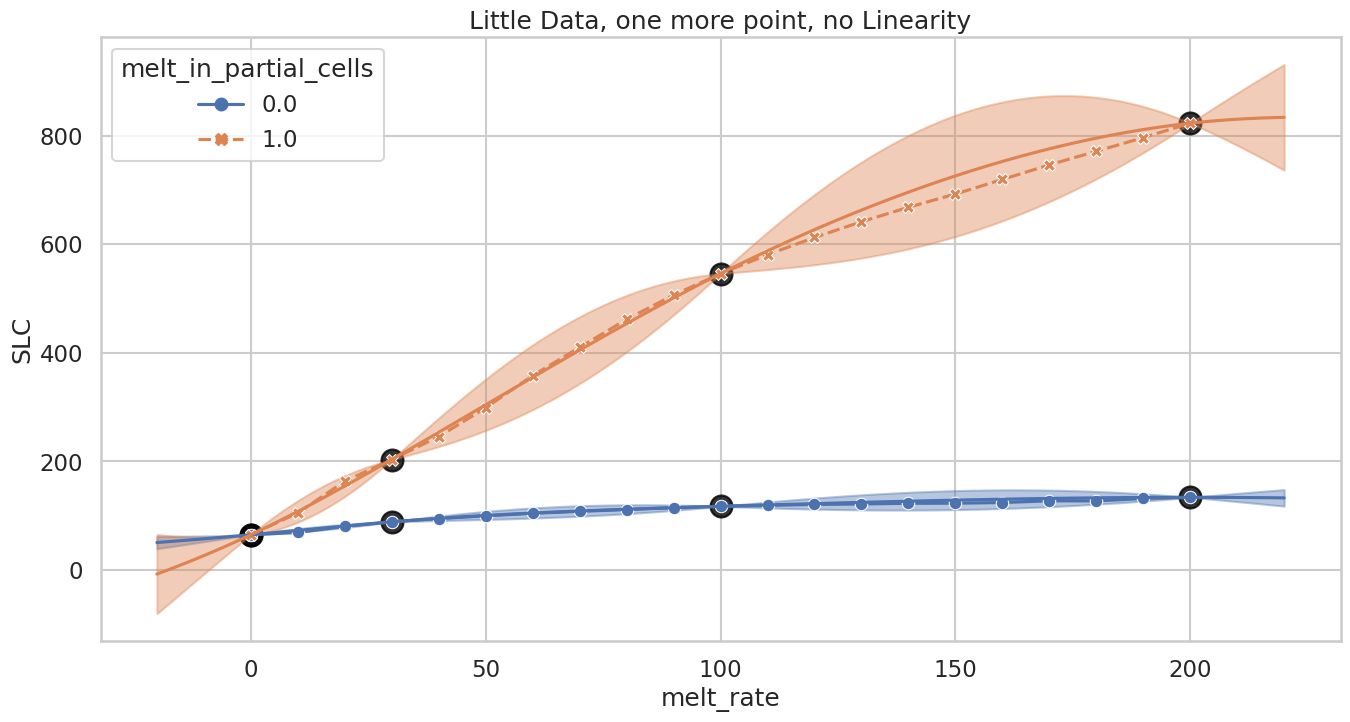

In [17]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 3, 10, 20]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 3, 10, 20]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, one more point, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/3, f = 37.492411301759006
Optimization restart 2/3, f = 37.49241024638677
Optimization restart 3/3, f = 37.492497329192084


gp.,value,constraints,priors
sum.ICM0.bias.variance,8.36843805359676,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.0031521723760329578,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,99.99824530092525,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.0,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


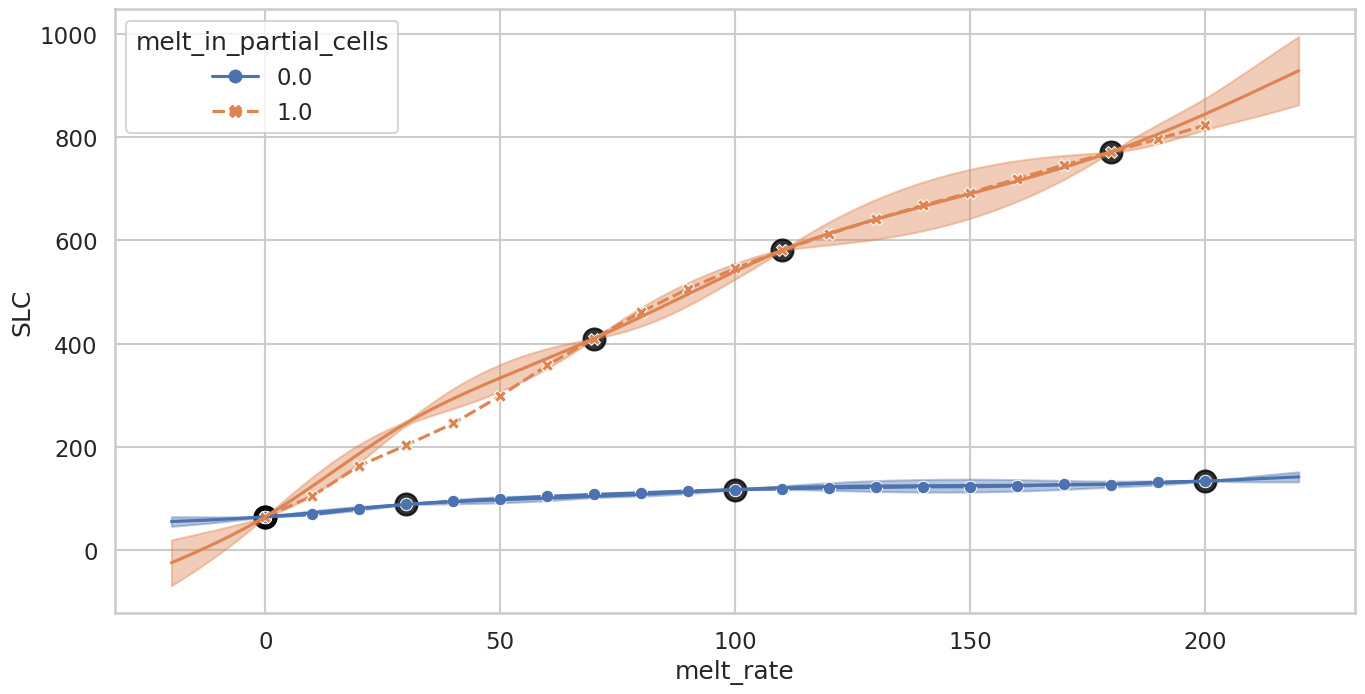

In [18]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 7, 11, 18]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 7, 11, 18]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
    with_linear=True,
)
plot_model(model, Xs_sub, ys_sub)
model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/3, f = 39.91790136238142
Optimization restart 2/3, f = 39.917886352204825
Optimization restart 3/3, f = 39.91788596857643


gp.,value,constraints,priors
sum.ICM0.bias.variance,6.015736948095149,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.010907723335195253,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,99.97245247707772,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.00000000045667,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


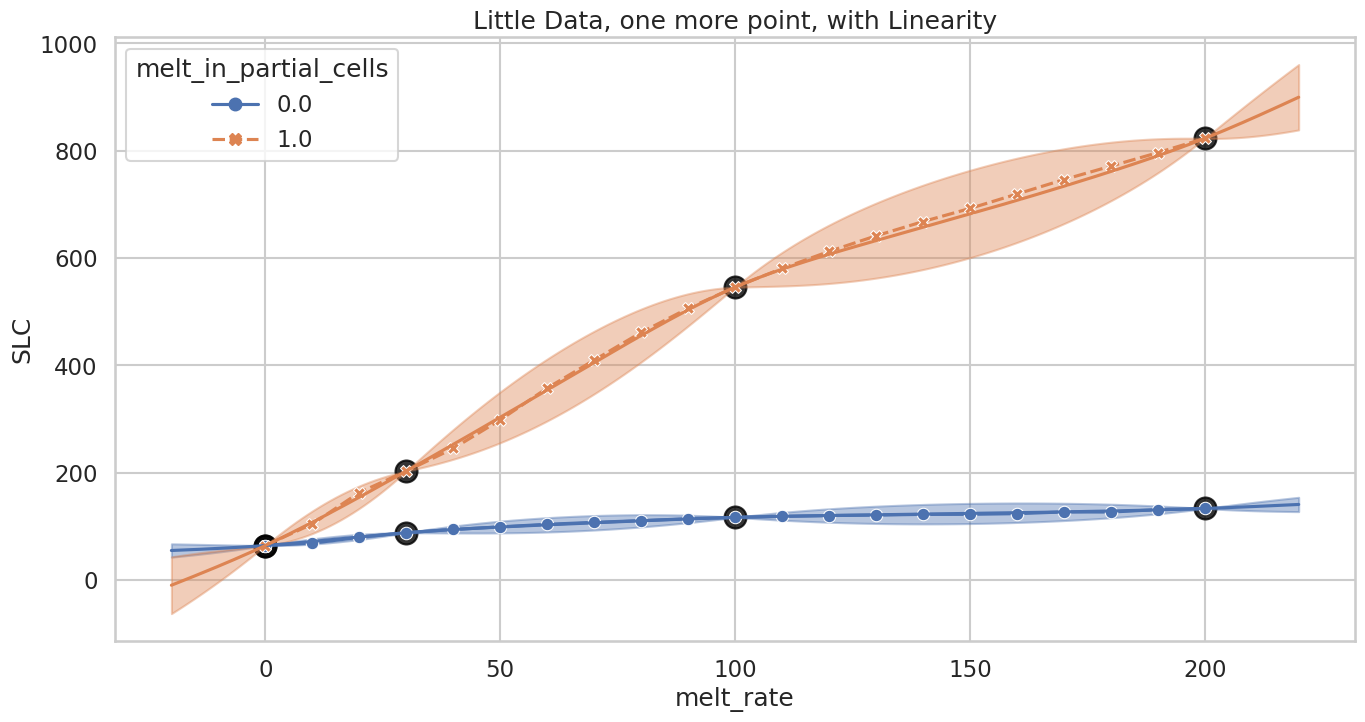

In [19]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 3, 10, 20]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 3, 10, 20]],
]


model = coreg_model(Xs_sub, ys_sub, with_linear=True)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, one more point, with Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/3, f = 71.96803137093328
Optimization restart 2/3, f = 71.96806241984854
Optimization restart 3/3, f = 71.96812643893048


gp.,value,constraints,priors
sum.ICM0.bias.variance,1.1386198592742005,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.99839471172388,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,222.49437771900332,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


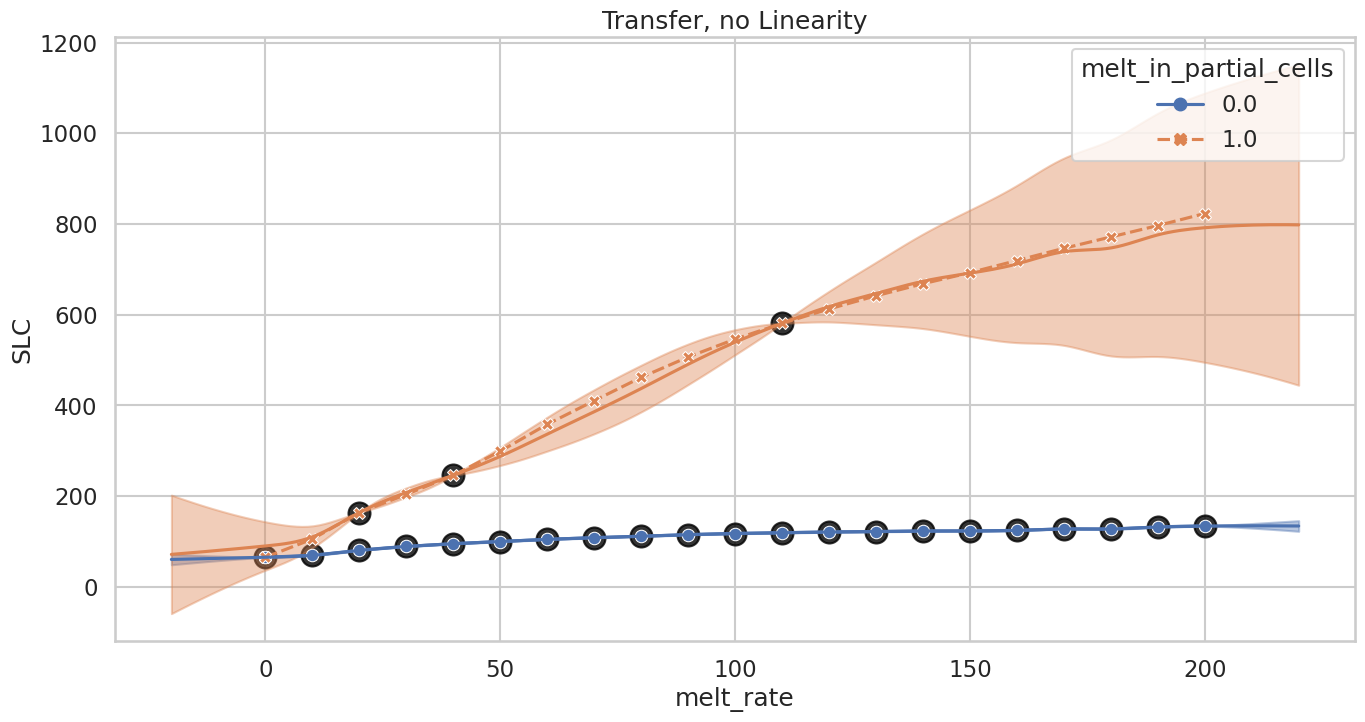

In [20]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, no Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/3, f = 77.8353604444252
Optimization restart 2/3, f = 77.83551230795541
Optimization restart 3/3, f = 77.83546982403679


gp.,value,constraints,priors
sum.ICM0.bias.variance,1.0918999640027465,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.99897256115217,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,223.49235739211593,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


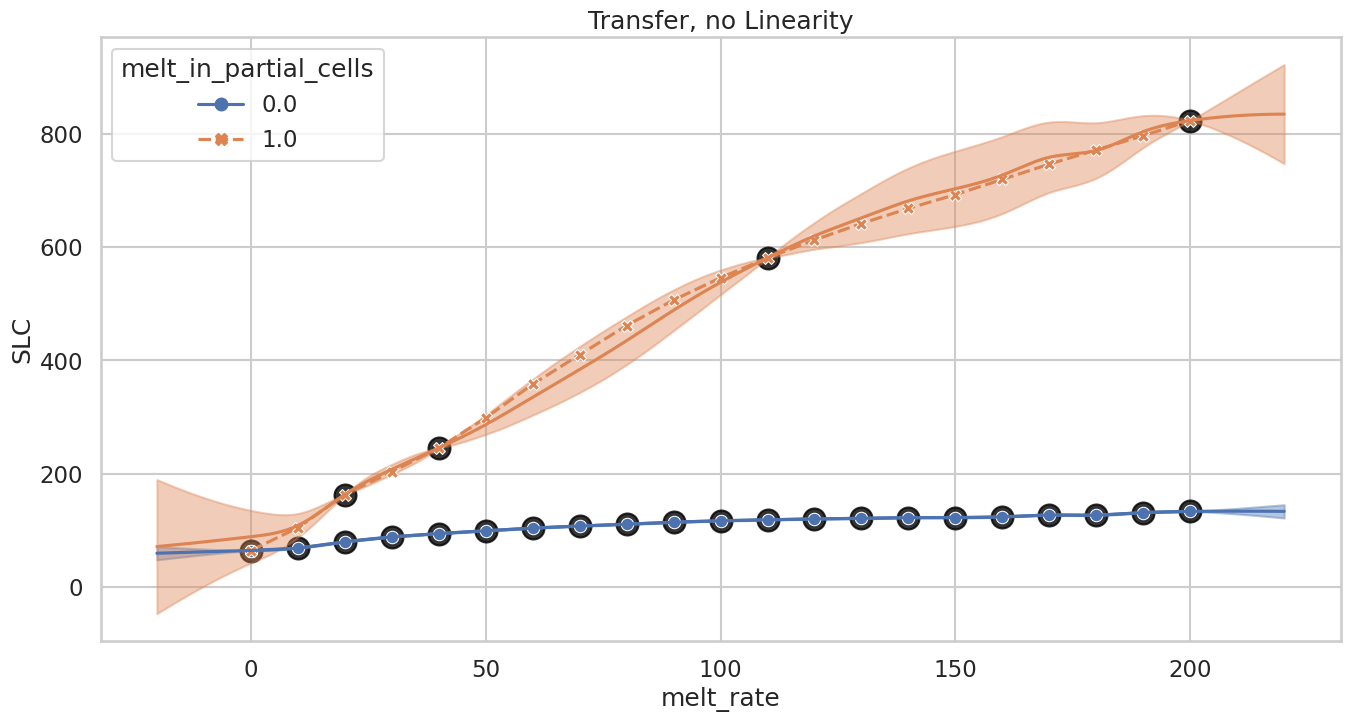

In [21]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11, 20]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11, 20]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/3, f = 55.19151506354014
Optimization restart 2/3, f = 58.11705892498614
Optimization restart 3/3, f = 56.58591893723283


gp.,value,constraints,priors
sum.ICM0.bias.variance,9.411289392349339,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.00030891534392437595,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,30.00000000000824,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.623291303348225,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


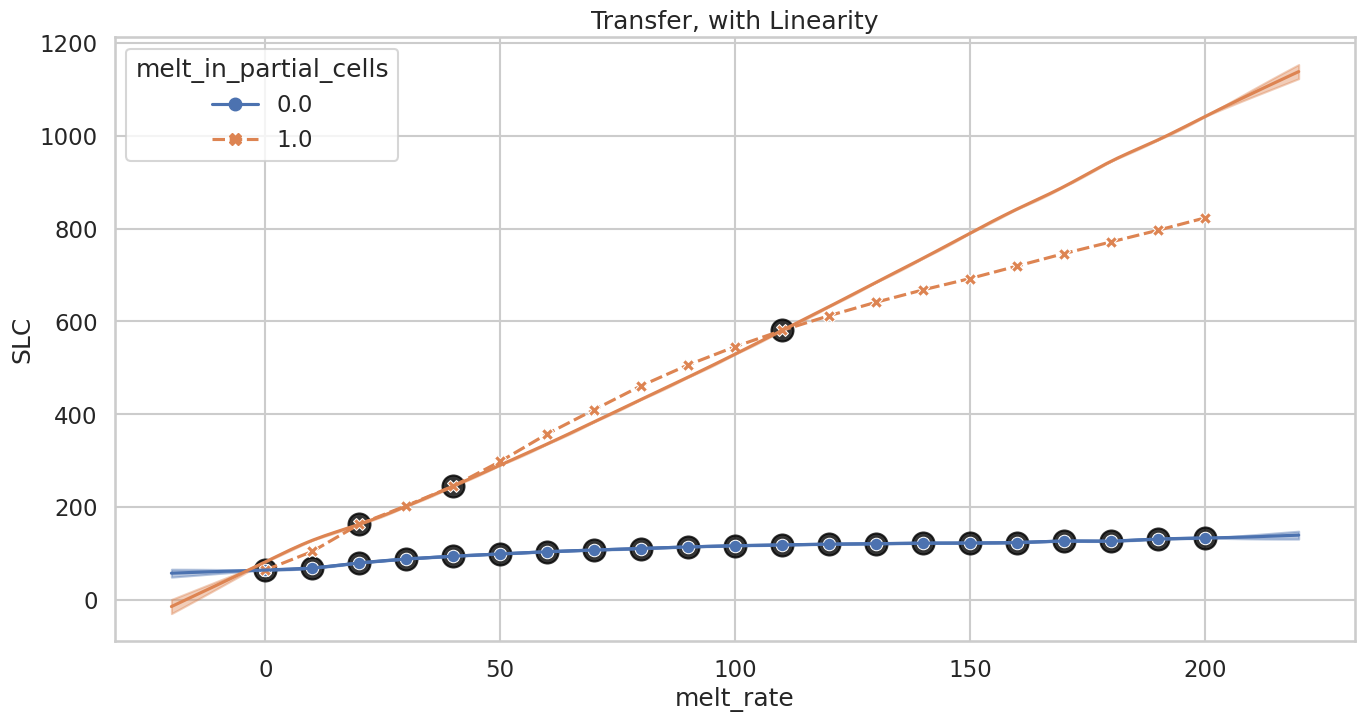

In [22]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
    with_linear=True,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, with Linearity")

model